In [46]:
## imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
%matplotlib inline

## Data Prep for Clustering

The following part of the notebook will prepare the datasets for the clustering task.

For clustering, only a select amount of features can be relevant. Since most clustering algorithms use distance based calcualtions to determine the clusters, input features need to be of numerical values. It is also important for them to be ordinal and continous. This becomes evidant when looking at time data. When looking at hourly datapaints for example, an entry at hour 23:00 and 01:00 would be classified as far apart instead of close to each other. 

After datasets only consist of suitable features (suitable features meaning potentially usable for the algorithm, not features that will actually be selected), the dataset will be normalised using the Standard Scaler importated from sklearn



In [111]:
# load dataset
charging_set_complete = pd.read_csv("data/cleaned_charging_set.csv")


In [97]:
# look at dataset again
charging_set_complete.head(10)

,id,kWhDelivered,siteID,spaceID,stationID,timezone,userID,connectionTime_date,connectionTime_time,disconnectTime_date,...,paymentRequired,requestedDeparture,UserID,WhPerMile_present,kWhRequested_present,milesRequested_present,minutesAvailable_present,modifiedAt_present,paymentRequired_present,requestedDeparture_present
0,5e23b149f9af8b5fe4b973cf,25.016,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,2020-01-02,13:08:54,2020-01-02,...,True,"Thu, 02 Jan 2020 20:51:54 GMT",1,1,1,1,1,1,1,1
1,5e23b149f9af8b5fe4b973d0,33.097,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,2020-01-02,13:36:50,2020-01-02,...,True,"Thu, 02 Jan 2020 23:31:50 GMT",1,1,1,1,1,1,1,1
2,5e23b149f9af8b5fe4b973d1,6.521,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,2020-01-02,13:56:35,2020-01-03,...,True,"Thu, 02 Jan 2020 14:56:35 GMT",1,1,1,1,1,1,1,1
3,5e23b149f9af8b5fe4b973d2,2.355,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,2020-01-02,13:59:58,2020-01-02,...,True,"Thu, 02 Jan 2020 15:04:58 GMT",1,1,1,1,1,1,1,1
4,5e23b149f9af8b5fe4b973d3,13.375,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,2020-01-02,14:00:01,2020-01-02,...,True,"Thu, 02 Jan 2020 22:24:01 GMT",1,1,1,1,1,1,1,1
5,5e23b149f9af8b5fe4b973d4,13.370,1,AG-1F13,1-1-194-821,America/Los_Angeles,3519.0,2020-01-02,14:00:13,2020-01-02,...,True,"Fri, 03 Jan 2020 00:24:13 GMT",1,1,1,1,1,1,1,1
6,5e23b149f9af8b5fe4b973d5,43.477,1,AG-1F09,1-1-178-817,America/Los_Angeles,933.0,2020-01-02,14:09:14,2020-01-03,...,True,"Fri, 03 Jan 2020 00:56:14 GMT",1,1,1,1,1,1,1,1
7,5e23b149f9af8b5fe4b973d6,32.441,1,AG-4F34,1-1-191-804,America/Los_Angeles,3737.0,2020-01-02,14:17:32,2020-01-03,...,True,"Thu, 02 Jan 2020 16:23:32 GMT",1,1,1,1,1,1,1,1
8,5e23b149f9af8b5fe4b973d7,13.264,1,AG-1F11,1-1-194-826,America/Los_Angeles,419.0,2020-01-02,14:25:38,2020-01-02,...,True,"Thu, 02 Jan 2020 22:36:38 GMT",1,1,1,1,1,1,1,1
9,5e23b149f9af8b5fe4b973d8,13.285,1,AG-1F08,1-1-178-823,America/Los_Angeles,651.0,2020-01-02,14:27:40,2020-01-02,...,True,"Thu, 02 Jan 2020 18:13:40 GMT",1,1,1,1,1,1,1,1


In [112]:

charging_set_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          66450 non-null  object 
 1   kWhDelivered                66450 non-null  float64
 2   siteID                      66450 non-null  int64  
 3   spaceID                     66450 non-null  object 
 4   stationID                   66450 non-null  object 
 5   timezone                    66450 non-null  object 
 6   userID                      49187 non-null  float64
 7   connectionTime_date         66450 non-null  object 
 8   connectionTime_time         66450 non-null  object 
 9   disconnectTime_date         66450 non-null  object 
 10  disconnectTime_time         66450 non-null  object 
 11  doneChargingTime_date       62362 non-null  object 
 12  doneChargingTime_time       62362 non-null  object 
 13  connectionTime_year         664

In [113]:
# method to calculate the actual chargingDuration instead of the connection time

def calc_realConnectionTime():
    charging_set_complete["tempDoneChargingTime"] = charging_set_complete["doneChargingTime_date"] + ' ' + charging_set_complete["doneChargingTime_time"]
    charging_set_complete["tempConnectionTime"] = charging_set_complete["connectionTime_date"] + ' ' + charging_set_complete["connectionTime_time"]
    charging_set_complete["dt_doneChargingTime_time"] = pd.to_datetime(charging_set_complete["tempDoneChargingTime"])
    charging_set_complete["dt_connectionTime_time"] = pd.to_datetime(charging_set_complete["tempConnectionTime"])
    
    charging_set_complete["real_connectionTimeTemp"] = charging_set_complete["dt_doneChargingTime_time"] - charging_set_complete["dt_connectionTime_time"]
    charging_set_complete['realChargingTime'] = charging_set_complete["real_connectionTimeTemp"].apply(
        lambda x: x.total_seconds() / 3600
    )
    charging_set_complete.drop(columns=["tempDoneChargingTime","tempConnectionTime","dt_doneChargingTime_time","dt_connectionTime_time","real_connectionTimeTemp"], inplace=True)

calc_realConnectionTime()
columns = ["realChargingTime","chargingDuration"]
charging_set_complete[columns].head(10)

,realChargingTime,chargingDuration
0,4.378056,6.039167
1,6.687500,9.025278
2,2.641944,10.713056
3,1.313056,2.644722
4,4.291389,8.144167
5,6.218889,9.007778
6,10.835278,11.812222
7,6.085556,10.456111
8,4.216944,5.174167
9,4.835000,5.568889


In [100]:
charging_set_complete.loc[1]

id                                 5e23b149f9af8b5fe4b973d0
kWhDelivered                                         33.097
siteID                                                    1
spaceID                                             AG-1F01
stationID                                       1-1-193-825
timezone                                America/Los_Angeles
userID                                               4275.0
connectionTime_date                              2020-01-02
connectionTime_time                                13:36:50
disconnectTime_date                              2020-01-02
disconnectTime_time                                22:38:21
doneChargingTime_date                            2020-01-02
doneChargingTime_time                              20:18:05
connectionTime_year                                    2020
connectionTime_month                                      1
connectionTime_day                                        2
disconnectTime_year                     

In [114]:
## only execute this once!

## drop boolean values

charging_set_complete = charging_set_complete.drop(["paymentRequired_present","WhPerMile_present","kWhRequested_present","milesRequested_present","minutesAvailable_present","modifiedAt_present","requestedDeparture_present"],axis = 1)

## dropping non numerical values in the dataset in order to allow normalisation using the StandardScaler later

charging_set_complete = charging_set_complete.drop(["userID", "id","siteID","spaceID","stationID","timezone","connectionTime_date","connectionTime_time","disconnectTime_date","disconnectTime_time","doneChargingTime_date","doneChargingTime_time","modifiedAt","paymentRequired","requestedDeparture"], axis=1)

## count number of unregistered user 

count_of_zero = charging_set_complete[charging_set_complete['UserID']==0].shape[0]

## split dataset into registered user
charging_set_registered = charging_set_complete[charging_set_complete["UserID"]==1]
charging_set_unregistered = charging_set_complete[charging_set_complete["UserID"]==0]

# drop User ID
charging_set_registered = charging_set_registered.drop("UserID",axis = 1)
charging_set_unregistered = charging_set_unregistered.drop("UserID", axis = 1)
charging_set_complete = charging_set_complete.drop("UserID", axis = 1)


In [18]:


# normalise registered User dataset 
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(charging_set_registered)
#cs_registered = scaler.transform(charging_set_registered)
#scaled_registered = pd.DataFrame(cs_registered, columns=charging_set_registered.columns,index = charging_set_registered.index)
#scaled_registered.head()

In [19]:
## drop NaN values, only execute once!!!

#charging_set_unregistered = charging_set_unregistered.drop(["WhPerMile","kWhRequested","milesRequested","minutesAvailable"],axis = 1)
# normalise unregistered dataset 
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(charging_set_unregistered)
#cs_unregistered = scaler.transform(charging_set_unregistered)
#sclaed_unregisterd = pd.DataFrame(cs_unregistered, columns=charging_set_unregistered.columns,index = charging_set_unregistered.index)
#sclaed_unregisterd.head()

In [20]:
# normalise entire dataset 
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(charging_set_complete)
#cs_complete = scaler.transform(charging_set_complete)
#scaled_all = pd.DataFrame(cs_complete, columns=charging_set_complete.columns,index = charging_set_complete.index)
#scaled_all.head()

In [115]:
charging_set_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   kWhDelivered            66450 non-null  float64
 1   connectionTime_year     66450 non-null  int64  
 2   connectionTime_month    66450 non-null  int64  
 3   connectionTime_day      66450 non-null  int64  
 4   disconnectTime_year     66450 non-null  int64  
 5   disconnectTime_month    66450 non-null  int64  
 6   disconnectTime_day      66450 non-null  int64  
 7   doneChargingTime_year   62362 non-null  float64
 8   doneChargingTime_month  62362 non-null  float64
 9   doneChargingTime_day    62362 non-null  float64
 10  chargingDuration        66450 non-null  float64
 11  WhPerMile               49187 non-null  float64
 12  kWhRequested            49187 non-null  float64
 13  milesRequested          49187 non-null  float64
 14  minutesAvailable        49187 non-null

## Clustering for entire dataset 

*note that entire dataset means all 68000 entries, but not every column*
In previous atempts outliers were deemed as probolem, so outlier detection is used now

In [116]:
## check dataframe for outliers

max_cD = charging_set_complete["chargingDuration"].max()
min_cD = charging_set_complete["chargingDuration"].min()

max_rCT = charging_set_complete["realChargingTime"].max()
min_rCT = charging_set_complete["realChargingTime"].min()


print(min_cD,max_cD,max_rCT,min_rCT)

0.0344444444444444 245.26916666666668 200.01583333333335 -0.6894444444444444


We can see that there are outliers that could impact the algorithms performance. 
Charging for 8 days is highly unrealistic, also the negative values are strange. A negative realChargingDuration can not be right. Let's count the amount of these outliers and see how much they impact the dataset. For a basic benchmark we are setting a lower boundery of 0.15 hours and an upper boundary. 

In [117]:
## amount of values not satisfying the threshold for realChargingTime

indices_rCT_under = charging_set_complete[charging_set_complete['realChargingTime'] < 0.15].index.tolist()
indices_rCT_over = charging_set_complete[charging_set_complete['realChargingTime'] > 72].index.tolist()
under_threshold_rCT = len(indices_rCT_under)
over_threshold_rCT = len(indices_rCT_over)

## amount of values not satisfying the threshold for chargingDuration 

indices_CD_under = charging_set_complete[charging_set_complete["chargingDuration"]< 0.15].index.to_list()
indices_CD_over = charging_set_complete[charging_set_complete["chargingDuration"] > 72].index.to_list()
under_threshold_cD = len(indices_CD_under)
over_threshold_cD = len(indices_CD_over)

print(under_threshold_cD,under_threshold_rCT,over_threshold_cD,over_threshold_rCT)




147 196 45 14


Summing up those outlier values, we reach a total of 402 entries outside of the threshold, which is an accaptable amount to neglect, since it is less than 1% of the data entries

In [118]:
## remove outliers

charging_set_complete = charging_set_complete[(charging_set_complete["chargingDuration"]<72) & (charging_set_complete["chargingDuration"]>0.15)]
charging_set_complete = charging_set_complete[(charging_set_complete["realChargingTime"]<72) & (charging_set_complete["realChargingTime"]>0.15)]
charging_set_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62119 entries, 0 to 66449
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   kWhDelivered            62119 non-null  float64
 1   connectionTime_year     62119 non-null  int64  
 2   connectionTime_month    62119 non-null  int64  
 3   connectionTime_day      62119 non-null  int64  
 4   disconnectTime_year     62119 non-null  int64  
 5   disconnectTime_month    62119 non-null  int64  
 6   disconnectTime_day      62119 non-null  int64  
 7   doneChargingTime_year   62119 non-null  float64
 8   doneChargingTime_month  62119 non-null  float64
 9   doneChargingTime_day    62119 non-null  float64
 10  chargingDuration        62119 non-null  float64
 11  WhPerMile               45929 non-null  float64
 12  kWhRequested            45929 non-null  float64
 13  milesRequested          45929 non-null  float64
 14  minutesAvailable        45929 non-null

In [119]:
## select features for initial clustering
clustering_df = charging_set_complete[["kWhDelivered","realChargingTime","chargingDuration"]]
clusters = []
losses = []

## set random kmax value
k_max = 30


In [120]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62119 entries, 0 to 66449
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kWhDelivered      62119 non-null  float64
 1   realChargingTime  62119 non-null  float64
 2   chargingDuration  62119 non-null  float64
dtypes: float64(3)
memory usage: 1.9 MB


#### Explaination of feature selection:

Time data can not be effectively used 


In [121]:
clustering_df.max()



kWhDelivered        108.797242
realChargingTime     45.462500
chargingDuration     67.186944
dtype: float64

In [122]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(clustering_df)
cluster_scaled = scaler.transform(clustering_df)
scaled_df = pd.DataFrame(cluster_scaled, columns= clustering_df.columns,index = clustering_df.index)
scaled_df.head()

,kWhDelivered,realChargingTime,chargingDuration
0,1.308391,0.321115,-0.073416
1,2.100994,1.193823,0.657049
2,-0.505640,-0.334938,1.069915
3,-0.914251,-0.837108,-0.903768
4,0.166616,0.288364,0.441511


In [123]:
scaled_df["realChargingTime"].max()

15.846371862814095

In [70]:
cluster_scaled

array([[ 1.30839111,  0.32111462, -0.07341601],
       [ 2.10099379,  1.19382252,  0.65704916],
       [-0.50564012, -0.33493834,  1.06991487],
       ...,
       [-0.03945518,  0.05659407, -0.65500219],
       [-0.00855927, -0.5415163 , -0.26619086],
       [-1.0572547 , -0.76782833, -0.90539885]])

In [124]:
for k in range(k_max):
    model = KMeans(n_clusters=k+1, n_init="auto")
    model.fit(cluster_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

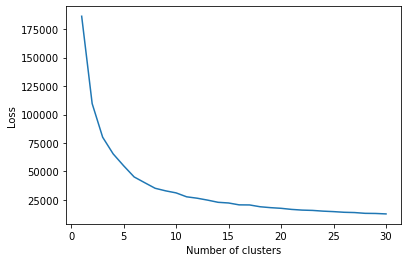

In [125]:
# plot loss in relation to cluster amount 
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(0.0, 15.0)

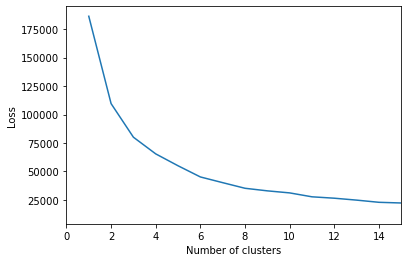

In [126]:
# zoom in 
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,15])

(0.0, 10.0)

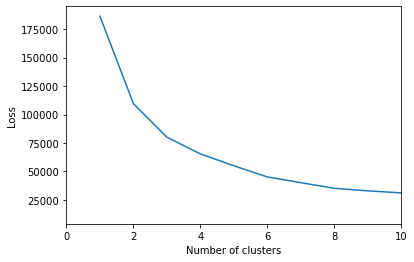

In [127]:
# zoom in again
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,10])

Sharpest fold at 2-6, therefore and appropriate cluster amount lies in that region. Let's pick 4 clusters for now

In [128]:
numbers = ["zero", "one", "two", "three"]

# refit algorithm
four_means = KMeans(n_clusters=4, n_init="auto")
four_means.fit(cluster_scaled)

# match records to clusters by calling predict
scaled_df["cluster"] = four_means.predict(cluster_scaled)
scaled_df["cluster"] = scaled_df["cluster"].apply(lambda x: numbers[x])

scaled_df.head()


,kWhDelivered,realChargingTime,chargingDuration,cluster
0,1.308391,0.321115,-0.073416,one
1,2.100994,1.193823,0.657049,one
2,-0.505640,-0.334938,1.069915,two
3,-0.914251,-0.837108,-0.903768,zero
4,0.166616,0.288364,0.441511,two


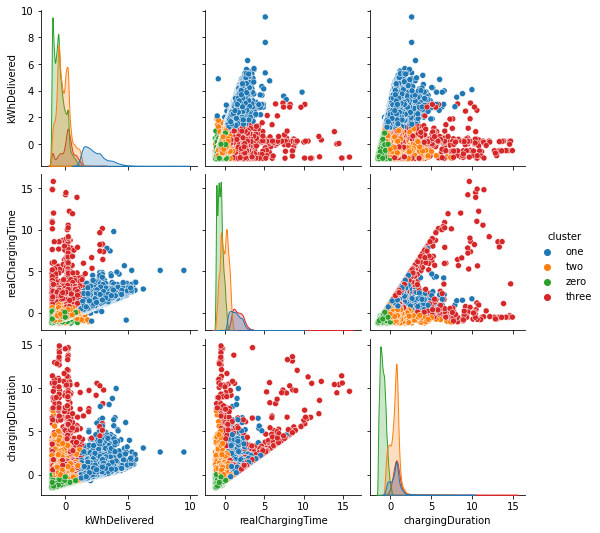

In [129]:
sns.pairplot(data=scaled_df, hue="cluster")

<AxesSubplot:xlabel='kWhDelivered', ylabel='realChargingTime'>

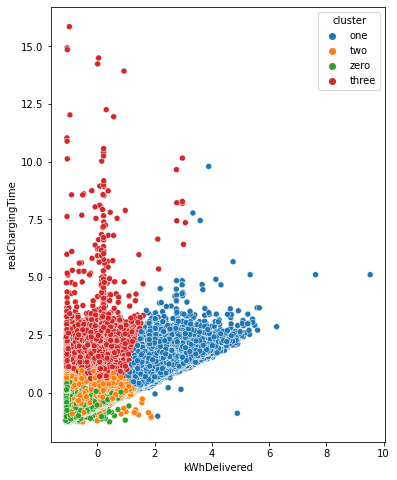

In [130]:
## plot only realChargingDuration

plt.figure(figsize=(6,8))
sns.scatterplot(data=scaled_df, x="kWhDelivered", y="realChargingTime", hue="cluster")

In [131]:
scaled_df.max()

kWhDelivered         9.525844
realChargingTime    15.846372
chargingDuration    14.884608
cluster                  zero
dtype: object

<AxesSubplot:xlabel='kWhDelivered', ylabel='chargingDuration'>

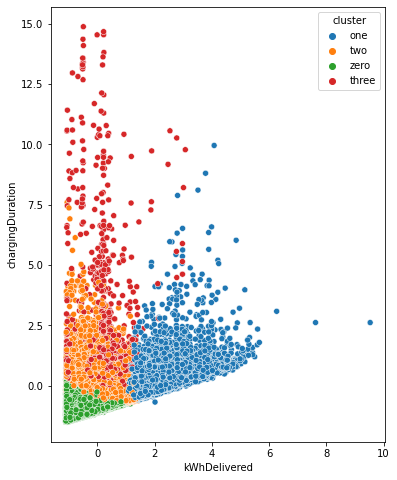

In [132]:
## plot only chargingDuration

plt.figure(figsize=(6,8))
sns.scatterplot(data=scaled_df, x="kWhDelivered", y="chargingDuration", hue="cluster")